## 数据探索EDA
	1）每日总购买与赎回量的时间序列图
	2）STL分解，将时序图拆分为：Trend + Seasonal + Residual

### 方法1：采用时间序列进行预测
    Step1，平稳性检测 adfuller
    Step2，采用 ARIMA模型
    Step3，模型训练集与预测
    
### 方法2：基于时序规则的挖掘
	Step1，获得周期因子（weekday）
	Step2，计算base
	Step3，使用base * 周期因子进行预测

In [1]:
import pandas as pd

#数据加载
data=pd.read_csv('./purchase_redeem/user_balance_table.csv',parse_dates=['report_date'])

In [2]:
data

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,1,2014-08-05,20385,20383,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
1,1,2014-08-08,20391,20389,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
2,1,2014-08-11,20397,20395,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
3,1,2014-08-14,20403,20401,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
4,1,2014-08-17,20409,20407,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2840416,28033,2014-08-25,550646,550585,61,0,0,0,0,0,0,0,0,61,NaN,NaN,NaN,NaN
2840417,28033,2014-08-31,525707,538147,60,0,0,0,12500,12500,0,0,0,60,0.0,0.0,0.0,12500.0
2840418,28033,2014-07-24,20487121,20484824,2297,0,0,0,0,0,0,0,0,2297,NaN,NaN,NaN,NaN
2840419,28033,2014-07-27,20462288,20491722,2298,0,0,0,31732,0,31732,0,31732,2298,NaN,NaN,NaN,NaN


In [3]:
total_balance=data.groupby(['report_date'])['total_purchase_amt','total_redeem_amt'].sum()
purchase=total_balance[['total_purchase_amt']]
redeem=total_balance[['total_redeem_amt']]

/Users/muyu/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


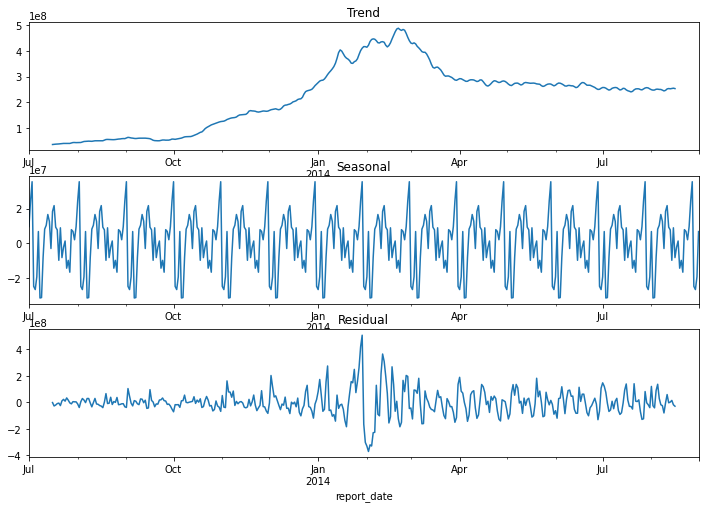

In [10]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

#指定区间范围内数据，进行可视化
def plot_stl(data):
    #STL返回三个部分：trend(趋势)，seasonal(季节)，residual(残差)
    result=sm.tsa.seasonal_decompose(data, period=30) #由于数据本身只有一年左右，如果季节周期设为一年就找不到季节规律(因为数据至少需要两个完整的季节周期)，所以设一个月
    #可视化
    fig=plt.figure(figsize=(12,8))
    ax1=fig.add_subplot(311)
    ax2=fig.add_subplot(312)
    ax3=fig.add_subplot(313)
    
    result.trend.plot(ax=ax1, title='Trend')
    result.seasonal.plot(ax=ax2, title='Seasonal')
    result.resid.plot(ax=ax3, title='Residual')
    
plot_stl(purchase.total_purchase_amt)

Importing plotly failed. Interactive plots will not work.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


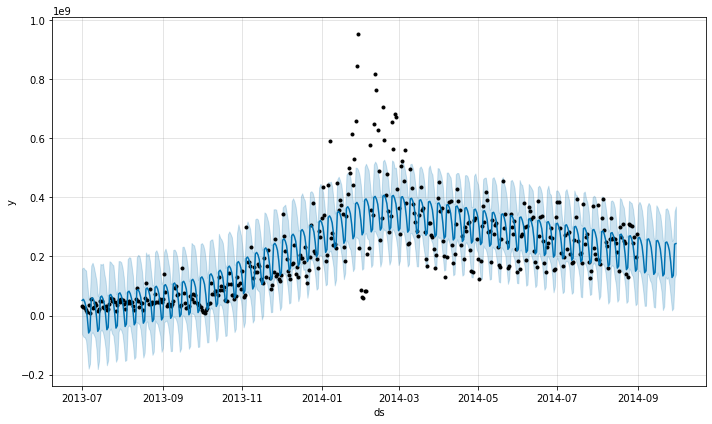

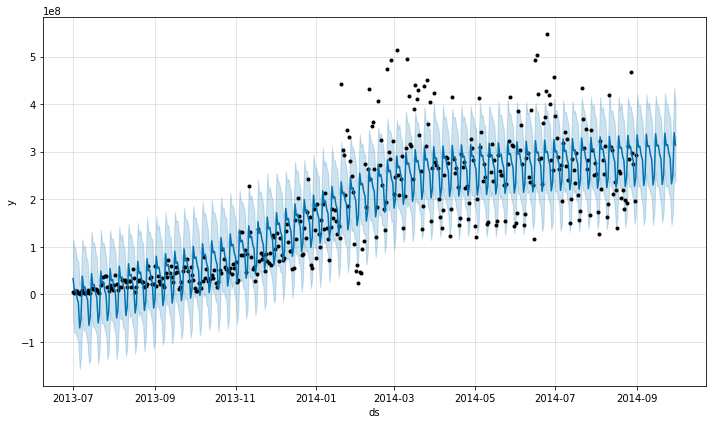

In [11]:
##Prophet模型
#将格式改为Prophet的输入格式
purchase['ds']=purchase.index
purchase.rename(columns={'total_purchase_amt':'y'}, inplace=True)
redeem['ds']=redeem.index
redeem.rename(columns={'total_redeem_amt':'y'}, inplace=True)

purchase=purchase.reset_index(drop=True)
redeem=redeem.reset_index(drop=True)

from fbprophet import Prophet

#拟合Prophet模型，预测purchase
model=Prophet(weekly_seasonality=True,seasonality_prior_scale=0.1,n_changepoints=300)
model.fit(purchase)
#预测未来1个月，9月份30天
future=model.make_future_dataframe(periods=30)
purchase_pred=model.predict(future)

model.plot(purchase_pred)

#拟合Prophet模型，预测redeem
model2=Prophet(weekly_seasonality=True,seasonality_prior_scale=0.1,n_changepoints=300)
model2.fit(redeem)
#预测未来1个月，9月份30天
future=model2.make_future_dataframe(periods=30)
redeem_pred=model2.predict(future)

model2.plot(redeem_pred)

#截取指定时间短的数据
purchase2=purchase_pred[(purchase_pred['ds']>='2014-09-01') & (purchase_pred['ds']<='2014-09-30')][['ds','yhat']]
redeem2=redeem_pred[(redeem_pred['ds']>='2014-09-01') & (redeem_pred['ds']<='2014-09-30')][['ds','yhat']]

#合并结果
result=pd.DataFrame()
result['ds']=purchase2.ds
result['purchase_amt']=purchase2.yhat
result['redeem_amt']=redeem2.yhat

#更改日期格式
result['ds']=result['ds'].apply(lambda x: str(x).replace('-','')[0:8])
result.to_csv('prophet.csv', header=None, index=False)

/Users/muyu/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/Users/muyu/opt/anaconda3/envs/NLP/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodel

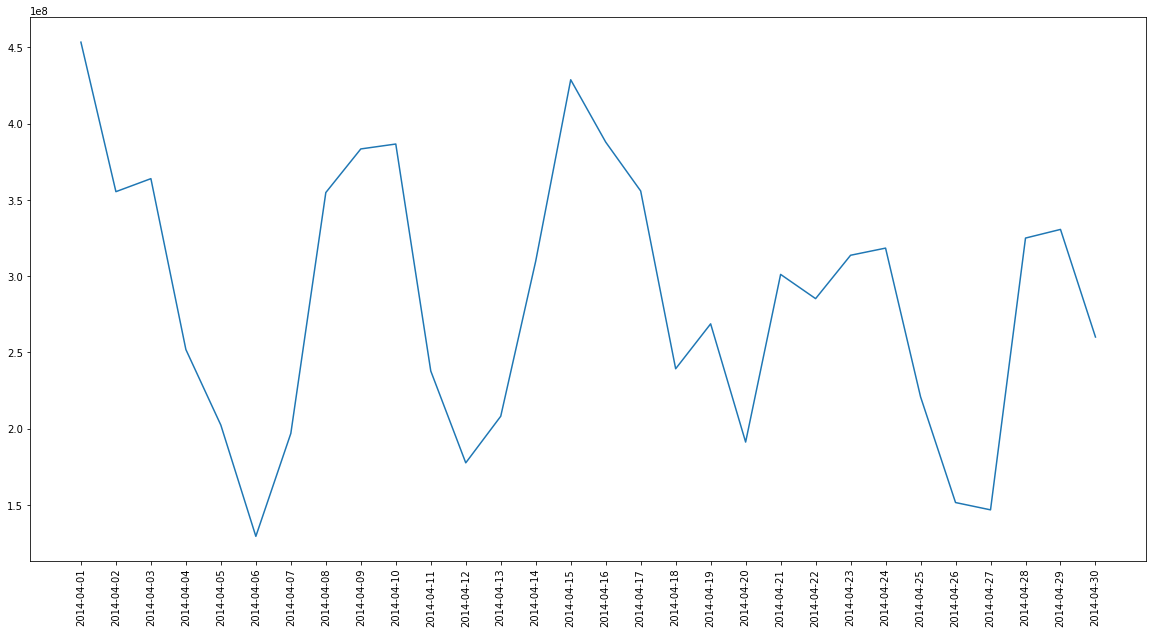

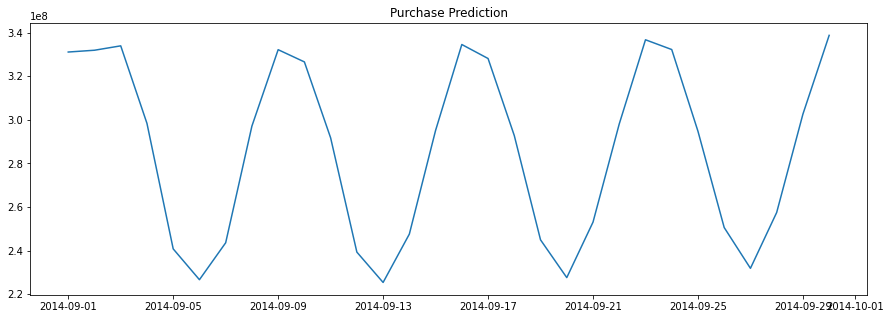

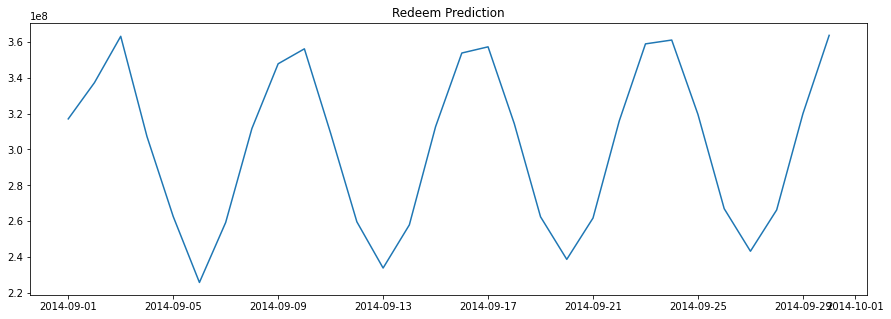

In [14]:
total_balance=data.groupby(['report_date'])['total_purchase_amt','total_redeem_amt'].sum()
purchase=total_balance[['total_purchase_amt']]
redeem=total_balance[['total_redeem_amt']]

##ARIMA模型
purchase2=purchase[(purchase.index >= '2014-04-01') & (purchase.index <= '2014-04-30')]
#画出走势图
plt.figure(figsize=(20,10))
plt.plot(purchase2.total_purchase_amt)
date_range=pd.date_range('2014-04-01','2014-04-30')
plt.xticks(date_range, rotation=90)

#看时间序列的平稳性
from statsmodels.tsa.stattools import adfuller
t=adfuller(purchase['total_purchase_amt'])
#结果不能拒绝原假设
#进行一阶差分
diff1=purchase.diff(1)
t=adfuller(diff1[1:])
#结果能够拒绝原假设

t=adfuller(redeem['total_redeem_amt'])
#结果不能拒绝原假设
#进行一阶差分
diff1=redeem.diff(1)
t=adfuller(diff1[1:])
#结果能够拒绝原假设

from statsmodels.tsa.arima_model import ARIMA
#p,d,q 其中d=1(因为一阶差分拒绝了原假设)
model=ARIMA(purchase, order=(7,1,5)).fit()
#使用typ='levels'对原始数据维度上进行预测，相当于进行了反差分
purchase_pred=model.predict('2014-09-01','2014-09-30',typ='levels')
model.aic

from statsmodels.tsa.arima_model import ARIMA
#p,d,q 其中d=1
model2=ARIMA(redeem, order=(7,1,5)).fit()
#使用typ='levels'对原始数据维度上进行预测，相当于进行了反差分
redeem_pred=model2.predict('2014-09-01','2014-09-30',typ='levels')
model2.aic

plt.figure(figsize=(15,5))
plt.title('Purchase Prediction')
plt.plot(purchase_pred)
plt.figure(figsize=(15,5))
plt.title('Redeem Prediction')
plt.plot(redeem_pred)
plt.show()

result=pd.DataFrame()
result['date']=purchase_pred.index
result['purchase']=purchase_pred.values
result['redeem']=redeem_pred.values

#更改日期格式
result['date']=result['date'].apply(lambda x: str(x).replace('-','')[0:8])
result.to_csv('arima.csv', header=None, index=False)